# Downloading Library

In [1]:
!pip install transformers datasets -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 564.2 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 25.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.0
    Uninstalling transformers-4.44.0:
      Successfully uninstalled transformers-4.44.0


# Loading Library

In [2]:
import pandas as pd
import numpy as np
from datasets import load_dataset, Dataset
from transformers import TrainingArguments, Trainer, DistilBertTokenizer, DistilBertForSequenceClassification
import torch
import seaborn as sns
import matplotlib.pyplot as plt

import re, string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Loading Data

## https://www.kaggle.com/datasets/mawro73/restaurant-reviews-for-nlp

In [3]:
data = pd.read_csv(r'/kaggle/input/restaurant-reviews-for-nlp/Restaurant_Reviews.tsv', delimiter="\t")
data.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [4]:
data.isnull().sum()

Review    0
Liked     0
dtype: int64

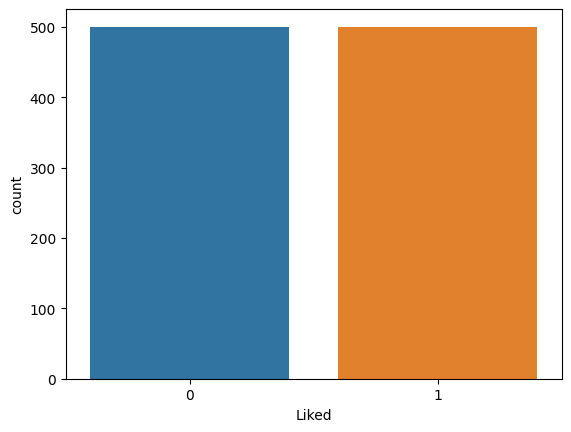

In [5]:
sns.countplot(x='Liked', data=data)
plt.show()

# Preprocessing In Data

In [6]:
punc = string.punctuation
ps = PorterStemmer()
sw = stopwords.words("english")

In [7]:
def preprocess(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.split()
    text = ' '.join([word for word in text if (word not in sw) and (word not in punc)])
    return text

In [8]:
data.head(2)

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0


In [9]:
data['Review'] = data['Review'].apply(preprocess)

In [10]:
data.columns = ['text', 'label']

In [11]:
data.head()

,text,label
0,wow love place,1
1,crust good,0
2,tasti textur nasti,0
3,stop late may bank holiday rick steve recommen...,1
4,select menu great price,1


# Start Using Transformers

## transform data into dataloader

In [12]:
new_data = Dataset.from_pandas(data)
new_data = new_data.train_test_split(train_size=0.8)
new_data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 800
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
})

In [13]:
new_data['train'][0]

{'text': 'check', 'label': 1}

## Download Tokenizer & Model

In [14]:
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Apply Toknization

In [15]:
def token(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length')

In [16]:
tokenized_datasets = new_data.map(token, batched=True)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [17]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 800
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
})

## Arguments

In [18]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=1000,
)

In [19]:
def compute_metrics(p):
    pred, label = p
    pred = pred.argmax(axis=1)
    return {'Accuracy': (pred == label).mean()}

In [20]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
    )

# Train The model

In [21]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


TrainOutput(global_step=100, training_loss=0.5294595718383789, metrics={'train_runtime': 65.7546, 'train_samples_per_second': 24.333, 'train_steps_per_second': 1.521, 'total_flos': 211947837849600.0, 'train_loss': 0.5294595718383789, 'epoch': 2.0})

In [22]:
trainer.evaluate(tokenized_datasets['test'])

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.49308720231056213,
 'eval_Accuracy': 0.805,
 'eval_runtime': 1.8137,
 'eval_samples_per_second': 110.274,
 'eval_steps_per_second': 3.86,
 'epoch': 2.0}

In [23]:
prediction = trainer.predict(tokenized_datasets['test'])[1]
prediction

array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1])

In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(tokenized_datasets['test']['label'], prediction)
acc = accuracy_score(tokenized_datasets['test']['label'], prediction)

print('THe Accuracy Of Testing Data is ---> ', acc*100)
cm

THe Accuracy Of Testing Data is --->  100.0


array([[ 99,   0],
       [  0, 101]])

# Make Prediction

In [40]:
model.save_pretrained('/kaggle/working/distilbert/model')
# Save the tokenizer
tokenizer.save_pretrained('/kaggle/working/distilbert/tokenizer')

('/kaggle/working/distilbert/tokenizer/tokenizer_config.json',
 '/kaggle/working/distilbert/tokenizer/special_tokens_map.json',
 '/kaggle/working/distilbert/tokenizer/vocab.txt',
 '/kaggle/working/distilbert/tokenizer/added_tokens.json')

In [42]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Example new texts
new_texts = [
    "food bare lukewarm must sit wait server bring us",
    "nicest restaur owner ever come across"
]

def predict(text):
    print('Input:', text)

    # Load tokenizer and model from the checkpoint
    tokenizer = DistilBertTokenizer.from_pretrained('/kaggle/working/distilbert/tokenizer')
    model = DistilBertForSequenceClassification.from_pretrained('/kaggle/working/distilbert/model')

    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

    # Ensure model is on the same device as input
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Convert logits to probabilities (using softmax)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Get the predicted class label
    predicted_class = torch.argmax(probabilities, dim=-1)

    return {
        "predicted_class": predicted_class.item(),
        "probabilities": probabilities.squeeze().tolist()
    }

# Test the prediction function
for text in new_texts:
    result = predict(text)
    print(f"Text: {text}")
    print(f"Predicted Class: {result['predicted_class']}")
    print(f"Class Probabilities: {result['probabilities']}")
    print("-" * 50)


Input: food bare lukewarm must sit wait server bring us
Text: food bare lukewarm must sit wait server bring us
Predicted Class: 0
Class Probabilities: [0.9248450398445129, 0.07515492290258408]
--------------------------------------------------
Input: nicest restaur owner ever come across
Text: nicest restaur owner ever come across
Predicted Class: 1
Class Probabilities: [0.11855385452508926, 0.881446123123169]
--------------------------------------------------
